In [1]:
from src import data
from src import mlp

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
# Buouy data paths for wave related measurements
DATA_PATH_2022 = 'data/targetstation46240/46240h2022.txt'
DATA_PATH_2021 = 'data/targetstation46240/46240h2021.txt'
DATA_PATH_2020 = 'data/targetstation46240/46240h2020.txt'
DATA_PATH_2019 = 'data/targetstation46240/46240h2019.txt'
DATA_PATH_2018 = 'data/targetstation46240/46240h2018.txt'
DATA_PATH_2017 = 'data/targetstation46240/46240h2017.txt'
DATA_PATH_2016 = 'data/targetstation46240/46240h2016.txt'
DATA_PATH_2015 = 'data/targetstation46240/46240h2015.txt'
DATA_PATH_2014 = 'data/targetstation46240/46240h2014.txt'
DATA_PATH_2013 = 'data/targetstation46240/46240h2013.txt'
DATA_PATH_2012 = 'data/targetstation46240/46240h2012.txt'
DATA_PATH_2011 = 'data/targetstation46240/46240h2011.txt'
DATA_PATH_2010 = 'data/targetstation46240/46240h2010.txt'
DATA_PATH_2009 = 'data/targetstation46240/46240h2009.txt'

In [3]:
file_paths = [DATA_PATH_2009,DATA_PATH_2010, DATA_PATH_2011, DATA_PATH_2012, DATA_PATH_2013, 
              DATA_PATH_2014, DATA_PATH_2015, DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, 
              DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]

station46240specs = ['WVHT', 'DPD', 'APD', 'MWD', 'WTMP']

In [4]:
# Re-reading and combining data from all files with outliers replaced by NaN
all_wave_data_46240 = pd.concat([data.process_file_to_hourly_last(file) for file in file_paths])

all_wave_data_46240.drop(columns=['WDIR', 'WSPD', 'GST', 'PRES', 'DEWP', 'VIS', 'TIDE', 'ATMP'], inplace=True)

In [5]:
all_wave_data_46240.shape

(116706, 9)

In [6]:
all_wave_data_46240[all_wave_data_46240.isnull().any(axis=1)]

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-04-06 23:00:00,2009,4,6,23,0.96,15.38,11.37,7.0,NaN
2009-04-07 00:00:00,2009,4,7,0,0.83,11.76,10.87,354.0,NaN
2009-04-08 01:00:00,2009,4,8,1,0.87,12.50,10.72,352.0,NaN
2009-04-08 02:00:00,2009,4,8,2,0.88,11.76,10.62,347.0,NaN
2009-04-08 03:00:00,2009,4,8,3,0.75,11.76,10.31,349.0,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-31 08:00:00,2022,8,31,8,0.20,NaN,5.65,NaN,15.7
2022-08-31 09:00:00,2022,8,31,9,0.21,NaN,5.84,NaN,15.6
2022-08-31 10:00:00,2022,8,31,10,0.23,NaN,5.85,NaN,15.6


In [7]:
# drop rows that contain NaN values
all_wave_data_46240.dropna(inplace=True)

Below 2 cells normalize the data–we will not be doing that for the very basic linear regressor

In [ ]:
# wvht_scaler = StandardScaler()
# all_wave_data_46240['WVHT'] = wvht_scaler.fit_transform(all_wave_data_46240[['WVHT']])

In [ ]:
# # normalize the input data since our features are on different scales / units
# columns_to_normalize = ['DPD', 'APD', 'MWD', 'WTMP']
# scaler_other = StandardScaler()
# all_wave_data_46240[columns_to_normalize] = scaler_other.fit_transform(all_wave_data_46240[columns_to_normalize])

In [8]:
all_wave_data_46240.head()

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,1.12,11.76,7.91,352.0,11.9
2009-01-01 01:00:00,2009,1,1,1,1.02,10.53,6.31,346.0,11.9
2009-01-01 02:00:00,2009,1,1,2,1.07,11.11,5.61,352.0,11.9
2009-01-01 03:00:00,2009,1,1,3,1.14,11.76,5.42,352.0,11.9
2009-01-01 04:00:00,2009,1,1,4,1.00,13.33,5.65,359.0,11.9


### Splitting the Data

In [9]:
train_df = all_wave_data_46240[all_wave_data_46240.index.year <= 2018]
val_df = all_wave_data_46240[(all_wave_data_46240.index.year == 2019) | (all_wave_data_46240.index.year == 2020)]

# WE WILL NOT TOUCH THIS UNTIL THE FINAL MODEL
test_df = all_wave_data_46240[(all_wave_data_46240.index.year == 2021) | (all_wave_data_46240.index.year == 2022)]

In [10]:
missing_indices_train = data.check_for_missing_rows(train_df)
len(missing_indices_train)

614

In [11]:
missing_indices_val = data.check_for_missing_rows(val_df)
len(missing_indices_val)

49

In [12]:
missing_indices_test = data.check_for_missing_rows(test_df)
len(missing_indices_test)

16

### Training Basic Linear Regressor

In [178]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                          window=12,
                                                          step=12,
                                                          lead=18)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

X_train shape: (76945, 60) y_train shape: (76945,)


In [179]:
X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                      window=12,
                                                      step=12,
                                                      lead=18)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (16037, 60) y_val shape: (16037,)


In [180]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.483
Model:                            OLS   Adj. R-squared (uncentered):              0.483
Method:                 Least Squares   F-statistic:                              1199.
Date:                Thu, 07 Dec 2023   Prob (F-statistic):                        0.00
Time:                        16:32:31   Log-Likelihood:                         -85310.
No. Observations:               76945   AIC:                                  1.707e+05
Df Residuals:                   76885   BIC:                                  1.713e+05
Df Model:                          60                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0273      0.004      6.305      0.000       0.019       0.036
x2             0.0100      0.003      2.946      0.003       0.003       0.017
x3             0.0211      0.004      5.065      0.000       0.013       0.029
x4            -0.0012      0.003     -0.406      0.684      -0.007       0.004
x5            -0.0197      0.009     -2.165      0.030      -0.037      -0.002
x6            -0.0100      0.005     -1.824      0.068      -0.021       0.001
x7             0.0040      0.004      1.130      0.258      -0.003       0.011
x8             0.0059      0.005      1.267      0.205      -0.003       0.015
x9            -0.0091      0.003     -3.112      0.002      -0.015      -0.003
x10           -0.0189      0.011     -1.745      0.081      -0.040       0.002
x11            0.0120      0.006      2.173      0.030       0.001       0.023
x12            0.0098      0.004      2.737      0.006       0.003       0.017
x13            0.0238      0.005      4.991      0.000       0.014       0.033
x14           -0.0035      0.003     -1.198      0.231      -0.009       0.002
x15            0.0356      0.011      3.132      0.002       0.013       0.058
x16            0.0040      0.006      0.729      0.466      -0.007       0.015
x17            0.0008      0.004      0.237      0.813      -0.006       0.008
x18            0.0264      0.005      5.496      0.000       0.017       0.036
x19            0.0036      0.003      1.237      0.216      -0.002       0.009
x20            0.0024      0.011      0.213      0.832      -0.020       0.025
x21            0.0010      0.006      0.186      0.852      -0.010       0.012
x22            0.0003      0.004      0.082      0.935      -0.007       0.007
x23            0.0101      0.005      2.100      0.036       0.001       0.020
x24            0.0020      0.003      0.693      0.489      -0.004       0.008
x25            0.0352      0.011      3.076      0.002       0.013       0.058
x26            0.0098      0.006      1.775      0.076      -0.001       0.021
x27           -0.0029      0.004     -0.802      0.423      -0.010       0.004
x28            0.0091      0.005      1.900      0.057      -0.000       0.019
x29           -0.0029      0.003     -0.993      0.321      -0.009       0.003
x30           -0.0553      0.011     -4.828      0.000      -0.078      -0.033
x31            0.0010      0.006      0.178      0.858      -0.010       0.012
x32            0.0080      0.004      2.232      0.026       0.001       0.015
x33           -0.0059      0.005     -1.223      0.221      -0.015       0.004
x34            0.0028      0.003      0.960      0.337      -0.003       0.009
x35           -0.0073      0.011     -0.640      0.522      -

In [181]:
from sklearn.metrics import mean_squared_error

predictions = result.predict(X_val)  
mse = mean_squared_error(y_val, predictions)  
print("Mean Squared Error:", mse)

Mean Squared Error: 0.46965517969194376


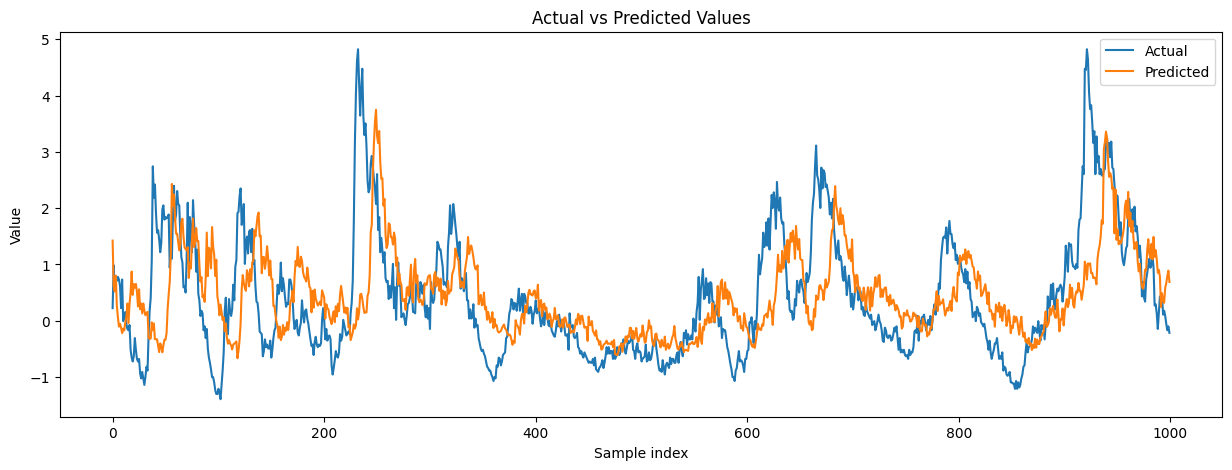

In [182]:
import matplotlib.pyplot as plt

N = 1000

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_val[:N], label='Actual')
plt.plot(predictions[:N], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.show()

The above is currently prediction with a lead of 18hrs

### Normalizing Data

In [111]:
wvht_scaler = StandardScaler()
all_wave_data_46240_scaled = all_wave_data_46240.copy()
all_wave_data_46240_scaled['WVHT'] = wvht_scaler.fit_transform(all_wave_data_46240[['WVHT']])

In [112]:
# normalize the input data since our features are on different scales / units
columns_to_normalize = ['DPD', 'APD', 'MWD', 'WTMP']
scaler_other = StandardScaler()
all_wave_data_46240_scaled[columns_to_normalize] = scaler_other.fit_transform(all_wave_data_46240[columns_to_normalize])

In [114]:
train_df_scaled = all_wave_data_46240_scaled[all_wave_data_46240_scaled.index.year <= 2018]
val_df_scaled = all_wave_data_46240_scaled[(all_wave_data_46240_scaled.index.year == 2019) | (all_wave_data_46240_scaled.index.year == 2020)]

# WE WILL NOT TOUCH THIS UNTIL THE FINAL MODEL
test_df_scaled = all_wave_data_46240_scaled[(all_wave_data_46240_scaled.index.year == 2021) | (all_wave_data_46240.index.year == 2022)]

In [116]:
missing_indices_train_scaled = data.check_for_missing_rows(train_df_scaled)
len(missing_indices_train_scaled)

614

In [117]:
missing_indices_val_scaled = data.check_for_missing_rows(val_df_scaled)
len(missing_indices_val_scaled)

49

In [118]:
missing_indices_test_scaled = data.check_for_missing_rows(test_df_scaled)
len(missing_indices_test_scaled)

16

### Simple XGBoost

In [144]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                          window=12,
                                                          step=12,
                                                          lead=48)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

X_train shape: (76915, 60) y_train shape: (76915,)


In [145]:
X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                      window=12,
                                                      step=12,
                                                      lead=48)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (16007, 60) y_val shape: (16007,)


In [175]:
from xgboost import XGBRegressor

bst = XGBRegressor(n_estimators=30, max_depth=6, eta=0.1, subsample=0.8, colsample_bytree=0.8)
bst.fit(X_train, y_train)
preds = bst.predict(X_val)

In [176]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, preds)  
print("Mean Squared Error:", mse)

Mean Squared Error: 0.6790143397278349


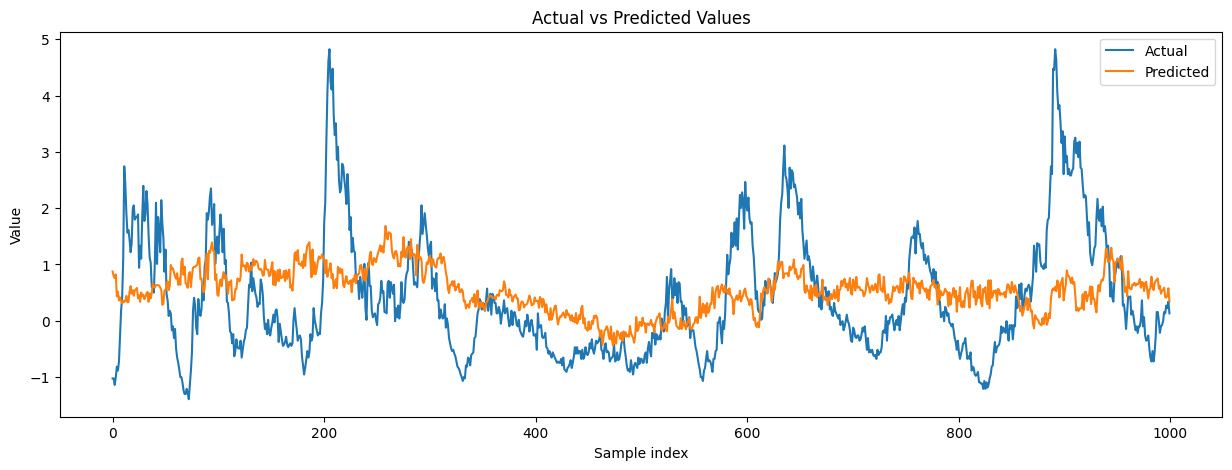

In [177]:
import matplotlib.pyplot as plt

N = 1000

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_val[:N], label='Actual')
plt.plot(preds[:N], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.show()

### Linear Regressor with Normalized Data

In [120]:
X_train_scaled, y_train_scaled = data.build_supervised_learning_dataset(dataframe=train_df_scaled,
                                                          missing_indices=missing_indices_train_scaled,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                          window=12,
                                                          step=12,
                                                          lead=48)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

X_train shape: (76915, 60) y_train shape: (76915,)


In [121]:
X_val_scaled, y_val_scaled = data.build_supervised_learning_dataset(dataframe=val_df_scaled,
                                                      missing_indices=missing_indices_val_scaled,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                      window=12,
                                                      step=12,
                                                      lead=48)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (16007, 60) y_val shape: (16007,)


In [123]:
import statsmodels.api as sm

model = sm.OLS(y_train_scaled, X_train_scaled)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.206
Model:                            OLS   Adj. R-squared (uncentered):              0.206
Method:                 Least Squares   F-statistic:                              332.8
Date:                Thu, 07 Dec 2023   Prob (F-statistic):                        0.00
Time:                        16:06:20   Log-Likelihood:                     -1.0187e+05
No. Observations:               76915   AIC:                                  2.039e+05
Df Residuals:                   76855   BIC:                                  2.044e+05
Df Model:                          60                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0119      0.005      2.212      0.027       0.001       0.022
x2             0.0085      0.004      2.035      0.042       0.000       0.017
x3             0.0354      0.005      6.840      0.000       0.025       0.046
x4            -0.0080      0.004     -2.235      0.025      -0.015      -0.001
x5            -0.0933      0.011     -8.274      0.000      -0.115      -0.071
x6             0.0121      0.007      1.777      0.076      -0.001       0.025
x7             0.0049      0.004      1.120      0.263      -0.004       0.014
x8             0.0057      0.006      0.988      0.323      -0.006       0.017
x9            -0.0109      0.004     -3.016      0.003      -0.018      -0.004
x10           -0.0178      0.013     -1.328      0.184      -0.044       0.008
x11            0.0134      0.007      1.954      0.051   -3.92e-05       0.027
x12            0.0147      0.004      3.319      0.001       0.006       0.023
x13            0.0159      0.006      2.687      0.007       0.004       0.028
x14           -0.0115      0.004     -3.149      0.002      -0.019      -0.004
x15            0.0270      0.014      1.913      0.056      -0.001       0.055
x16            0.0214      0.007      3.118      0.002       0.008       0.035
x17            0.0061      0.004      1.371      0.170      -0.003       0.015
x18            0.0227      0.006      3.806      0.000       0.011       0.034
x19           -0.0109      0.004     -3.010      0.003      -0.018      -0.004
x20            0.0349      0.014      2.456      0.014       0.007       0.063
x21         4.436e-05      0.007      0.006      0.995      -0.013       0.013
x22            0.0062      0.004      1.393      0.164      -0.003       0.015
x23            0.0370      0.006      6.200      0.000       0.025       0.049
x24           -0.0075      0.004     -2.056      0.040      -0.015      -0.000
x25            0.0184      0.014      1.296      0.195      -0.009       0.046
x26            0.0250      0.007      3.656      0.000       0.012       0.038
x27            0.0033      0.004      0.744      0.457      -0.005       0.012
x28            0.0320      0.006      5.364      0.000       0.020       0.044
x29           -0.0067      0.004     -1.851      0.064      -0.014       0.000
x30            0.0271      0.014      1.906      0.057      -0.001       0.055
x31           -0.0020      0.007     -0.287      0.774      -0.015       0.011
x32           -0.0013      0.004     -0.299      0.765      -0.010       0.007
x33            0.0213      0.006      3.562      0.000       0.010       0.033
x34            0.0025      0.004      0.675      0.500      -0.005       0.010
x35           -0.0183      0.014     -1.287      0.198      -

In [124]:
from sklearn.metrics import mean_squared_error

predictions = result.predict(X_val_scaled)  
mse = mean_squared_error(y_val_scaled, predictions)  
print("Mean Squared Error:", mse)

Mean Squared Error: 0.6999556588461411


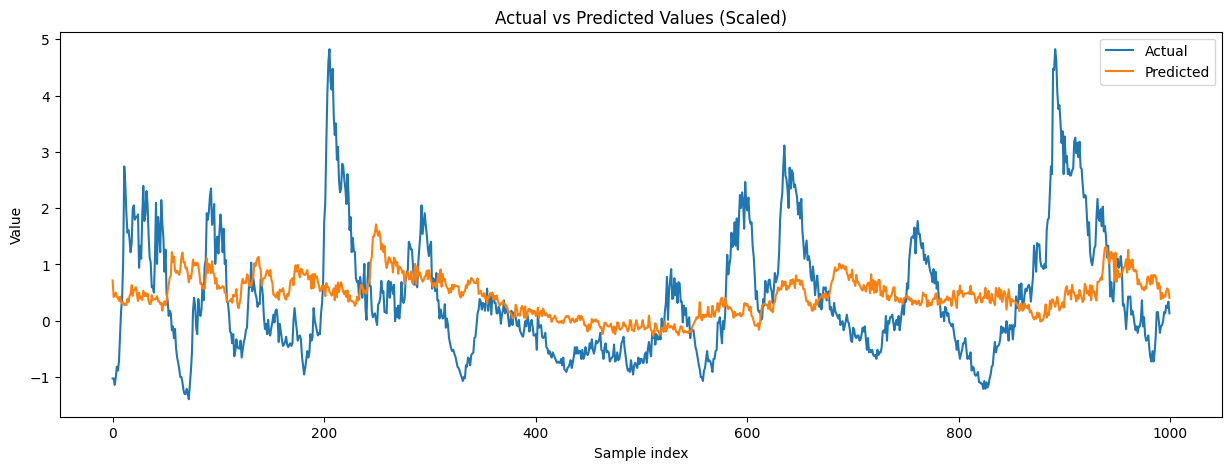

In [125]:
predictions_np = predictions.reshape(-1, 1)  # Reshape for scaler
y_val_np = y_val_scaled.reshape(-1, 1)              # Reshape for scaler

# Unscale predictions and actual values
predictions_unscaled = wvht_scaler.inverse_transform(predictions_np).flatten()
y_val_unscaled = wvht_scaler.inverse_transform(y_val_np).flatten()
        
plt.figure(figsize=(15, 5))
plt.plot(y_val_unscaled[:1000], label='Actual')
plt.plot(predictions_unscaled[:1000], label='Predicted')
plt.title('Actual vs Predicted Values (Scaled)')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.show()

### Long Short-Term Memory

In [126]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                          window=12,
                                                          step=12,
                                                          lead=48)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

X_train shape: (76915, 60) y_train shape: (76915,)


In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

def build_multistep_lstm_model(input_shape, output_steps):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(50))
    model.add(Dropout(0.3))
    model.add(Dense(output_steps))  # Output layer with 96 neurons for 96 hours prediction
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build the model
input_shape = (60)  # 48 hours, 9 features
output_steps = 48  # Predicting the next 48 hours
lstm_model = build_multistep_lstm_model(input_shape, output_steps)
lstm_model.summary()

TypeError: 'int' object is not iterable

In [133]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class PredictionHistory(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        self.predictions = []
    
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val)
        self.predictions.append(y_pred)

# Instantiate the callback with validation data
prediction_history = PredictionHistory(X_val, y_val)

# Fit the model with the new callback
history = lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, 
                         validation_data=(X_val, y_val), 
                         callbacks=[prediction_history])

Epoch 1/25


ValueError: in user code:

    File "/Users/calvinlaughlin/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/calvinlaughlin/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/calvinlaughlin/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/calvinlaughlin/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/calvinlaughlin/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/calvinlaughlin/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 48, 9), found shape=(None, 60)
